# Passive Learning (Manual)

## 1. Data Preprocessing

In [10]:
# Birth-Death Record Linkage Analysis
# A comprehensive record linkage system for linking birth and death records

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from datasketch import MinHash, MinHashLSH
# from jellyfish import jaro_winkler, damerau_levenshtein_distance
from jellyfish import jaro_similarity, jaro_winkler_similarity, levenshtein_distance, damerau_levenshtein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Birth-Death Record Linkage System")
print("=" * 50)

# %% [markdown]
# ## Step 1: Data Preprocessing


# %%
# Load the datasets
print("Loading datasets...")

# clean data (3k)
# birth_df = pd.read_csv('linkage data/data_3k/clean/birth_records.csv')
# death_df = pd.read_csv('linkage data/data_3k/clean/death_records.csv')

# corrupted data (3k)
birth_df = pd.read_csv('linkage data/data_3k/corrupted/_1/birth_records.csv')
death_df = pd.read_csv('linkage data/data_3k/corrupted/_1/death_records.csv')

print(f"Birth records: {birth_df.shape[0]} rows, {birth_df.shape[1]} columns")
print(f"Death records: {death_df.shape[0]} rows, {death_df.shape[1]} columns")

# %%
# Examine the structure of both datasets
print("\nBirth Records Columns:")
print(birth_df.columns.tolist())
print(f"\nDeath Records Columns:")
print(death_df.columns.tolist())

# %%
# Check for missing values
print("\nMissing values in Birth Records:")
print(birth_df.isnull().sum().head(35))
print(f"\nMissing values in Death Records:")
print(death_df.isnull().sum().head(10))

# %%
# Data preprocessing - select relevant columns for linkage
birth_columns = [
    'ID', 'child\'s forname(s)', 'child\'s surname', 'sex', 
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'birth year', 'address', 'Death'
]

death_columns = [
    'ID', 'forename(s) of deceased', 'surname of deceased', 'sex',
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'year', 'address', 'age at death'
]

# Create clean datasets
birth_clean = birth_df[birth_columns].copy()
death_clean = death_df[death_columns].copy()

# Rename columns for consistency
birth_clean.columns = ['birth_id', 'forename', 'surname', 'sex', 
                       'father_forename', 'father_surname', 'father_occupation',
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'birth_year', 'address', 'death_link']

death_clean.columns = ['death_id', 'forename', 'surname', 'sex',
                       'father_forename', 'father_surname', 'father_occupation', 
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'death_year', 'address', 'age_at_death']

# Fill missing values with empty strings for string columns
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'father_occupation', 'mother_forename', 'mother_surname', 
               'mother_occupation', 'address']

for col in string_cols:
    birth_clean[col] = birth_clean[col].fillna('').astype(str)
    death_clean[col] = death_clean[col].fillna('').astype(str)

print(f"\nCleaned Birth Records: {birth_clean.shape}")
print(f"Cleaned Death Records: {death_clean.shape}")


Birth-Death Record Linkage System
Loading datasets...
Birth records: 2508 rows, 35 columns
Death records: 1832 rows, 37 columns

Birth Records Columns:
['Death', 'MOTHER_IDENTITY', "father's forename", "father's occupation", 'sex', 'FATHER_BIRTH_RECORD_IDENTITY', "day of parents' marriage", "place of parent's marriage", 'CHILD_IDENTITY', "mother's occupation", 'family', 'illegit', 'DEATH_RECORD_IDENTITY', "father's surname", 'MARRIAGE_RECORD_IDENTITY3', 'birth day', 'MARRIAGE_RECORD_IDENTITY2', 'PARENT_MARRIAGE_RECORD_IDENTITY', 'MARRIAGE_RECORD_IDENTITY1', "month of parents' marriage", 'MARRIAGE_RECORD_IDENTITY4', 'MARRIAGE_RECORD_IDENTITY5', 'FATHER_IDENTITY', "mother's forename", "child's forname(s)", "mother's maiden surname", 'birth year', 'address', 'ID', 'MOTHER_BIRTH_RECORD_IDENTITY', 'notes', "child's surname", 'marriage', "year of parents' marriage", 'birth month']

Death Records Columns:
['if father deceased', 'MOTHER_IDENTITY', "father's forename", 'death code A', "father's

### Ground-truth function

In [11]:

# %%
# Create ground truth labels using Death column from birth records and ID from death records
def create_ground_truth(birth_df, death_df):
    """Create ground truth labels for record pairs"""
    ground_truth = []
    
    # Create a mapping of death IDs for quick lookup
    death_ids = set(death_df['death_id'].values)
    
    for _, birth_row in birth_df.iterrows():
        birth_id = birth_row['birth_id']
        death_link = birth_row['death_link']
        
        for _, death_row in death_df.iterrows():
            death_id = death_row['death_id']
            
            # True match if death_link matches death_id
            if pd.notna(death_link) and int(death_link) == death_id: # connected the ground truth
                label = 1  # Match
            else:
                label = 0  # No match
                
            ground_truth.append({
                'birth_id': birth_id,
                'death_id': death_id,
                'label': label
            })
    
    return pd.DataFrame(ground_truth)

ground_truth_df = create_ground_truth(birth_clean, death_clean)
print(f"\nGround truth created: {len(ground_truth_df)} record pairs")
print(f"Positive matches: {ground_truth_df['label'].sum()}")
print(f"Negative matches: {len(ground_truth_df) - ground_truth_df['label'].sum()}")



Ground truth created: 4594656 record pairs
Positive matches: 1001
Negative matches: 4593655


In [12]:
# ground_truth_df.loc[ground_truth_df['label'] == 1]
print(ground_truth_df)
print(ground_truth_df.loc[ground_truth_df['label'] == 1])

         birth_id  death_id  label
0            3020       922      0
1            3020      1755      0
2            3020      1254      0
3            3020      1900      0
4            3020      3274      0
...           ...       ...    ...
4594651      6276      1916      0
4594652      6276      2524      0
4594653      6276      1923      0
4594654      6276      1925      0
4594655      6276      2239      0

[4594656 rows x 3 columns]
         birth_id  death_id  label
1082         3020      3020      1
2915         3022      3022      1
4757         3050      3050      1
26841        3352      3352      1
40184        6342      6342      1
...           ...       ...    ...
4570715      6238      6238      1
4572548      6240      6240      1
4574381      6242      6242      1
4575695      3360      3360      1
4583543      6262      6262      1

[1001 rows x 3 columns]


## 2. Indexing (Blocking)

In [13]:
def create_minhash_signature(record, columns):
    """Create MinHash signature for a record"""
    minhash = MinHash()
    for col in columns:
        data = str(record[col]).lower()
        for token in data.split():
            minhash.update(token.encode('utf8'))
    return minhash

def blocking_with_minhash(birth_df, death_df, threshold):
    """Create blocks using MinHash LSH"""
    print(f"Creating blocks with threshold: {threshold}")
    
    # Columns to use for blocking
    blocking_cols = ['forename', 'surname', 'father_surname', 'mother_surname']
    
    # Create MinHash signatures for all records
    birth_signatures = {}
    death_signatures = {}
    
    print("Creating MinHash signatures for birth records...")
    for idx, row in birth_df.iterrows():
        birth_signatures[f"birth_{row['birth_id']}"] = create_minhash_signature(row, blocking_cols)
    
    print("Creating MinHash signatures for death records...")
    for idx, row in death_df.iterrows():
        death_signatures[f"death_{row['death_id']}"] = create_minhash_signature(row, blocking_cols)
    
    # Create LSH index
    lsh = MinHashLSH(threshold=threshold)
    
    # Insert all signatures
    print("Inserting signatures into LSH index...")
    for key, sig in birth_signatures.items():
        lsh.insert(key, sig)
    for key, sig in death_signatures.items():
        lsh.insert(key, sig)
    
    # Generate candidate pairs and detailed blocking information
    candidate_pairs = []
    birth_blocks = {}  # Dictionary to store blocks for each birth record
    
    print("Generating candidate pairs...")
    for birth_key, birth_sig in birth_signatures.items():
        similar_records = lsh.query(birth_sig)
        birth_id = int(birth_key.split('_')[1])
        
        # Find death records in the same block
        death_records_in_block = []
        for similar_key in similar_records:
            if similar_key.startswith('death_'):
                death_id = int(similar_key.split('_')[1])
                candidate_pairs.append((birth_id, death_id))
                death_records_in_block.append(death_id)
        
        # Store block information (just for statistical purposes)
        birth_blocks[birth_id] = {
            'birth_id': birth_id,
            'death_records': death_records_in_block,
            'total_similar_records': len(similar_records),
            'death_count': len(death_records_in_block)
        }
    
    # Remove duplicates from candidate pairs
    candidate_pairs = list(set(candidate_pairs))
    
    print(f"Generated {len(candidate_pairs)} candidate pairs") # for computation
    print(f"Generated {len(birth_blocks)} birth blocks") # for illustration, exploration
    
    return candidate_pairs, birth_blocks

# Generate candidate pairs through blocking
candidate_pairs, birth_blocks = blocking_with_minhash(birth_clean, death_clean, threshold=0.7)


Creating blocks with threshold: 0.7
Creating MinHash signatures for birth records...
Creating MinHash signatures for death records...
Inserting signatures into LSH index...
Generating candidate pairs...
Generated 1312 candidate pairs
Generated 2508 birth blocks


- checking the candidate pair that is same with the birth_blocks variable
- the diff is only the data types
- And, birth_blocks count the one that dont have the death (candidate)

In [14]:
def checking_candidate_pairs_by_ID(checking_id):
    r = []
    for i in range(len(candidate_pairs)):
        if candidate_pairs[i][0] == checking_id:
            r.append(candidate_pairs[i])
    print(f"\nCandidate pairs for birth ID {checking_id}: {r}")
    print(f"Total candidate pairs for birth ID {checking_id}: {len(r)}")

checking_candidate_pairs_by_ID(checking_id=3054)
checking_candidate_pairs_by_ID(checking_id=3114)
checking_candidate_pairs_by_ID(checking_id=3239)




Candidate pairs for birth ID 3054: [(3054, 3054), (3054, 3347)]
Total candidate pairs for birth ID 3054: 2

Candidate pairs for birth ID 3114: [(3114, 3239), (3114, 3494), (3114, 3827), (3114, 3555), (3114, 3114)]
Total candidate pairs for birth ID 3114: 5

Candidate pairs for birth ID 3239: [(3239, 3827), (3239, 3114), (3239, 3555), (3239, 3239), (3239, 3494)]
Total candidate pairs for birth ID 3239: 5


### Blocking Statistics


Detailed Blocking Analysis:
Sample Blocks (First 15 Birth Records):
----------------------------------------
Block 1:
  Birth ID: 3020
  Associated Death Records: [3020]
  Number of Death Records: 1
  Total Similar Records: 2
  Birth Record: Sarah Novak
  Death Record(s):
    ID 3020: Sarah Novak
---
Block 2:
  Birth ID: 3022
  Associated Death Records: [3022]
  Number of Death Records: 1
  Total Similar Records: 3
  Birth Record: Margaret Soto
  Death Record(s):
    ID 3022: Margaret Soto
---
Block 3:
  Birth ID: 3050
  Associated Death Records: [3050]
  Number of Death Records: 1
  Total Similar Records: 2
  Birth Record: Margeret Larsson
  Death Record(s):
    ID 3050: Margeret Larsson
---
Block 4:
  Birth ID: 3362
  Associated Death Records: []
  Number of Death Records: 0
  Total Similar Records: 1
  Birth Record: Marion CONLLY
  No death records in this block
---
Block 5:
  Birth ID: 6278
  Associated Death Records: []
  Number of Death Records: 0
  Total Similar Records: 1
  Bi

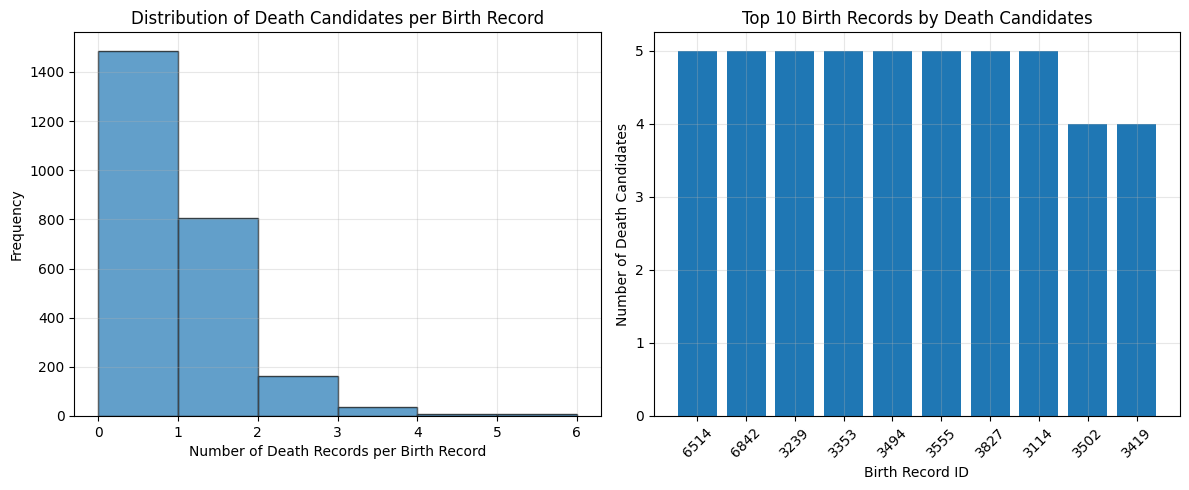


Birth Records with Multiple Death Candidates:
--------------------------------------------------
Found 214 birth records with multiple death candidates:

Birth ID 6514: Jemima Garcia
  Death candidates (5):
    ID 3555: John Garcia (Age: 7)
    ID 3239: James Garcia (Age: 69)
    ID 3827: Robert Garcia (Age: 2)
    ID 3114: Ellen Garcia (Age: 32)
    ID 3494: Mary Garcia (Age: 21)

Birth ID 6842: Grace Garcia
  Death candidates (5):
    ID 3555: John Garcia (Age: 7)
    ID 3239: James Garcia (Age: 69)
    ID 3827: Robert Garcia (Age: 2)
    ID 3114: Ellen Garcia (Age: 32)
    ID 3494: Mary Garcia (Age: 21)

Birth ID 3239: James Garcia
  Death candidates (5):
    ID 3555: John Garcia (Age: 7)
    ID 3239: James Garcia (Age: 69)
    ID 3827: Robert Garcia (Age: 2)
    ID 3114: Ellen Garcia (Age: 32)
    ID 3494: Mary Garcia (Age: 21)

Birth ID 3353: Andrew Garcia
  Death candidates (5):
    ID 3555: John Garcia (Age: 7)
    ID 3239: James Garcia (Age: 69)
    ID 3827: Robert Garcia (Age

In [15]:
# Show detailed blocking results
print("\nDetailed Blocking Analysis:")
print("=" * 50)

# Show first 15 birth records and their associated death records
print("Sample Blocks (First 15 Birth Records):")
print("-" * 40)

birth_ids_sample = list(birth_blocks.keys())[:15]
for i, birth_id in enumerate(birth_ids_sample):
    block_info = birth_blocks[birth_id]
    print(f"Block {i+1}:")
    print(f"  Birth ID: {birth_id}")
    print(f"  Associated Death Records: {block_info['death_records']}")
    print(f"  Number of Death Records: {block_info['death_count']}")
    print(f"  Total Similar Records: {block_info['total_similar_records']}")
    
    # Show names for context
    birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
    print(f"  Birth Record: {birth_record['forename']} {birth_record['surname']}")
    
    if block_info['death_records']:
        print(f"  Death Record(s):")
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']}")
    else:
        print(f"  No death records in this block")
    print("---")

# %%
# Statistical analysis of blocking results
print(f"\nBlocking Statistics:")
print("=" * 30)

death_counts = [block_info['death_count'] for block_info in birth_blocks.values()]
birth_records_with_deaths = sum(1 for count in death_counts if count > 0)
birth_records_without_deaths = sum(1 for count in death_counts if count == 0)

print(f"Total birth records: {len(birth_blocks)}")
print(f"Birth records with death candidates: {birth_records_with_deaths}")
print(f"Birth records without death candidates: {birth_records_without_deaths}")
print(f"Average death candidates per birth record: {np.mean(death_counts):.2f}")
print(f"Max death candidates for a single birth record: {max(death_counts)}")

# %%
# Distribution of death record counts per birth record
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(death_counts, bins=range(max(death_counts)+2), alpha=0.7, edgecolor='black')
plt.xlabel('Number of Death Records per Birth Record')
plt.ylabel('Frequency')
plt.title('Distribution of Death Candidates per Birth Record')
plt.grid(True, alpha=0.3)

# Show birth records with most death candidates
plt.subplot(1, 2, 2)
top_candidates = sorted(birth_blocks.items(), key=lambda x: x[1]['death_count'], reverse=True)[:10]
birth_ids = [str(item[0]) for item in top_candidates]
death_counts_top = [item[1]['death_count'] for item in top_candidates]

plt.bar(birth_ids, death_counts_top)
plt.xlabel('Birth Record ID')
plt.ylabel('Number of Death Candidates')
plt.title('Top 10 Birth Records by Death Candidates')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Show birth records with multiple death candidates
print(f"\nBirth Records with Multiple Death Candidates:")
print("-" * 50)

multiple_candidates = {birth_id: info for birth_id, info in birth_blocks.items() 
                      if info['death_count'] > 1}

if multiple_candidates:
    print(f"Found {len(multiple_candidates)} birth records with multiple death candidates:")
    
    for birth_id, block_info in sorted(multiple_candidates.items(), 
                                      key=lambda x: x[1]['death_count'], reverse=True)[:10]:
        birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
        print(f"\nBirth ID {birth_id}: {birth_record['forename']} {birth_record['surname']}")
        print(f"  Death candidates ({block_info['death_count']}):")
        
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']} "
                      f"(Age: {death_record['age_at_death']})")
else:
    print("No birth records have multiple death candidates with this threshold.")

# %%
# Summary table
print(f"\nBlocking Summary Table:")
print("=" * 25)

summary_data = []
for count in range(max(death_counts) + 1):
    freq = death_counts.count(count)
    percentage = (freq / len(death_counts)) * 100
    summary_data.append({
        'Death_Candidates': count,
        'Birth_Records': freq,
        'Percentage': f"{percentage:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


## 3. Comparing
### Feature
- from append()
- these are the features in each columns
1. jaro winkler
2. damerau levenshtein
3. jaccard similarity
4. age consistency 

In [16]:

# %% [markdown]
# ## Step 3: Comparing (Feature Engineering)

# %%
def jaccard_similarity(str1, str2):
    """Calculate Jaccard similarity between two strings"""
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    if len(set1.union(set2)) == 0:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_features(birth_record, death_record):
    """Calculate similarity features between two records"""
    features = []
    
    # String comparison columns
    string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
                   'mother_forename', 'mother_surname', 'address']
    
    for col in string_cols:
        birth_val = str(birth_record[col]).lower()
        death_val = str(death_record[col]).lower()
        
        # Jaro-Winkler similarity
        jw_sim = jaro_winkler_similarity(birth_val, death_val)
        features.append(jw_sim)
        # features.append({'col': col, 'jw_sim': jw_sim})
        
        # Damerau-Levenshtein distance (normalized)
        dl_dist = damerau_levenshtein_distance(birth_val, death_val)
        max_len = max(len(birth_val), len(death_val))
        dl_sim = 1 - (dl_dist / max_len) if max_len > 0 else 1
        features.append(dl_sim)
        # features.append({'col': col, 'dl_sim': dl_sim})
        
        # Jaccard similarity
        jaccard_sim = jaccard_similarity(birth_val, death_val)
        features.append(jaccard_sim)
        # features.append({'col': col, 'jaccard_sim': jaccard_sim})
    
    # Age consistency (if available)
    # if pd.notna(birth_record['birth_year']) and pd.notna(death_record['death_year']) and pd.notna(death_record['age_at_death']):
    #     expected_birth_year = death_record['death_year'] - death_record['age_at_death']
    #     age_diff = abs(birth_record['birth_year'] - expected_birth_year)
    #     age_consistency = 1 / (1 + age_diff)  # Exponential decay
    #     features.append(age_consistency)
    #     # features.append({'col': 'age_consistency', 'value': age_consistency})
    # else:
    #     features.append(0.5)  # Neutral value when age info is missing
    #     # features.append({'col': 'age_consistency', 'value': 0.5})

    try:
        # Convert to numeric, handling potential string inputs
        birth_year = pd.to_numeric(birth_record['birth_year'], errors='coerce')
        death_year = pd.to_numeric(death_record['death_year'], errors='coerce')  
        age_at_death = pd.to_numeric(death_record['age_at_death'], errors='coerce')
        
        if pd.notna(birth_year) and pd.notna(death_year) and pd.notna(age_at_death):
            expected_birth_year = death_year - age_at_death
            age_diff = abs(birth_year - expected_birth_year)
            age_consistency = 1 / (1 + age_diff)  # Exponential decay
            # features.append({'col': 'age_consistency', 'value': age_consistency})
            features.append(age_consistency)
        else:
            # features.append({'col': 'age_consistency', 'value': 0.5})
            features.append(0.5)
    except:
        # Fallback if conversion fails
        # features.append({'col': 'age_consistency', 'value': 0.5})
        features.append(0.5)
    
    return features

# Create feature matrix
print("Calculating features for candidate pairs...")
X = []
y = []

# Create lookup dictionaries for faster access
birth_lookup = {row['birth_id']: row for _, row in birth_clean.iterrows()}
death_lookup = {row['death_id']: row for _, row in death_clean.iterrows()}
ground_truth_lookup = {(row['birth_id'], row['death_id']): row['label'] 
                      for _, row in ground_truth_df.iterrows()}

for birth_id, death_id in candidate_pairs: # use candidate pairs only
    if birth_id in birth_lookup and death_id in death_lookup:
        birth_record = birth_lookup[birth_id]
        death_record = death_lookup[death_id]
        
        features = calculate_features(birth_record, death_record)
        X.append(features)
        
        # Get ground truth label
        label = ground_truth_lookup.get((birth_id, death_id))
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive class ratio: {np.sum(y)/len(y):.4f}")


Calculating features for candidate pairs...
Feature matrix shape: (1312, 25)
Labels shape: (1312,)
Positive class ratio: 0.6715


In [17]:
# y[0:20]
X[5]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
y


array([1, 0, 0, ..., 1, 1, 1], shape=(1312,))

## 4. Classification
### Cross Validation (5 folds)
- with Metrics performance; Precision, Recall, F1
- draw Plots

In [ ]:

# %%
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## randomly select 100 candidate pairs for testing *****



print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training positive ratio: {np.sum(y_train)/len(y_train):.4f}")
print(f"Test positive ratio: {np.sum(y_test)/len(y_test):.4f}")

# %%
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %%
# Cross-Validation Analysis (on training data only)
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

print("\nPerforming Cross-Validation Analysis (Training Data Only)...")
print("=" * 60)

# %%
# Check if we have enough samples for cross-validation
if len(np.unique(y_train)) < 2:
    print("Warning: Only one class present in the training data. Cannot perform classification.")
    print("This might indicate:")
    print("1. Threshold too high (try lowering it)")
    print("2. Ground truth issues")
    print("3. No actual matches in the candidate pairs")
    
    # Show class distribution
    unique_classes, counts = np.unique(y_train, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        print(f"Class {cls}: {count} samples")
else:
    # Define custom scorers
    scoring = {
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }

    # %%
    # Perform 5-fold stratified cross-validation on training data only
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("5-Fold Stratified Cross-Validation Results (Training Data Only):")
    print("-" * 60)

    # Initialize classifier for CV
    rf_classifier = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    )

    # Perform cross-validation on training data only
    cv_results = cross_validate(
        rf_classifier, X_train_scaled, y_train, 
        cv=cv, scoring=scoring, 
        return_train_score=True,
        n_jobs=-1
    )

    # %%
    # Display cross-validation results
    metrics = ['precision', 'recall', 'f1']
    for metric in metrics:
        test_scores = cv_results[f'test_{metric}'] # test_precision, test_recall, test_f1
        train_scores = cv_results[f'train_{metric}'] # train_precision, train_recall, train_f1
        
        print(f"\n{metric.upper()}:")
        print(f"  Training:    {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
        print(f"  Validation:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
        print(f"  CV Folds:    {test_scores}")




Training set: 918 samples
Test set: 394 samples
Training positive ratio: 0.6710
Test positive ratio: 0.6726

Performing Cross-Validation Analysis (Training Data Only)...
5-Fold Stratified Cross-Validation Results (Training Data Only):
------------------------------------------------------------

PRECISION:
  Validation:  0.9823 (+/- 0.0254)
  Training:    0.9824 (+/- 0.0063)
  CV Folds:    [0.97619048 0.99166667 0.99193548 0.99186992 0.96      ]

RECALL:
  Validation:  0.9854 (+/- 0.0239)
  Training:    0.9943 (+/- 0.0030)
  CV Folds:    [0.99193548 0.96747967 1.         0.99186992 0.97560976]

F1:
  Validation:  0.9838 (+/- 0.0198)
  Training:    0.9883 (+/- 0.0041)
  CV Folds:    [0.984      0.97942387 0.99595142 0.99186992 0.96774194]


### Fit the model and do the prediction

In [20]:

# %%
# Train Random Forest classifier on training set
print(f"\n\nTraining Final Model on Training Set:")
print("-" * 40)


rf_classifier.fit(X_train_scaled, y_train)

# %%
# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1] # select all rows, 1 col

print(y_pred)
print("-"* 40)
count_of_ones = (y_pred == 1).sum()
count_of_zeros = (y_pred == 0).sum()
print("COunt of 0: ", count_of_zeros)
print("COunt of 1: ", count_of_ones)
print("-"* 40)
print(y_pred_proba)
print("Classification completed!")




Training Final Model on Training Set:
----------------------------------------
[0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0
 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1
 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1
 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1
 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1
 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1]
----------------------------------------
COunt of 0:  126
COunt of 1:  268
----------------------------------------
[1.

## 5. Evaluation
- with the test set

Classification Results:
Precision: 0.9888
Recall: 1.0000
F1-Score: 0.9944

Confusion Matrix:
[[126   3]
 [  0 265]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       129
           1       0.99      1.00      0.99       265

    accuracy                           0.99       394
   macro avg       0.99      0.99      0.99       394
weighted avg       0.99      0.99      0.99       394



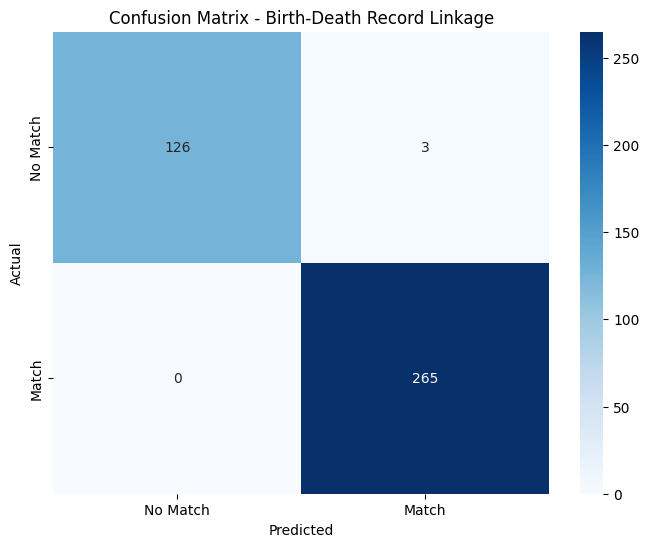


Top 10 Most Important Features:
                    feature  importance
24          age_consistency    0.484067
16       mother_forename_dl    0.056696
1               forename_dl    0.055075
0               forename_jw    0.049523
15       mother_forename_jw    0.047692
9        father_forename_jw    0.045878
10       father_forename_dl    0.039876
2          forename_jaccard    0.039502
17  mother_forename_jaccard    0.031713
11  father_forename_jaccard    0.025943


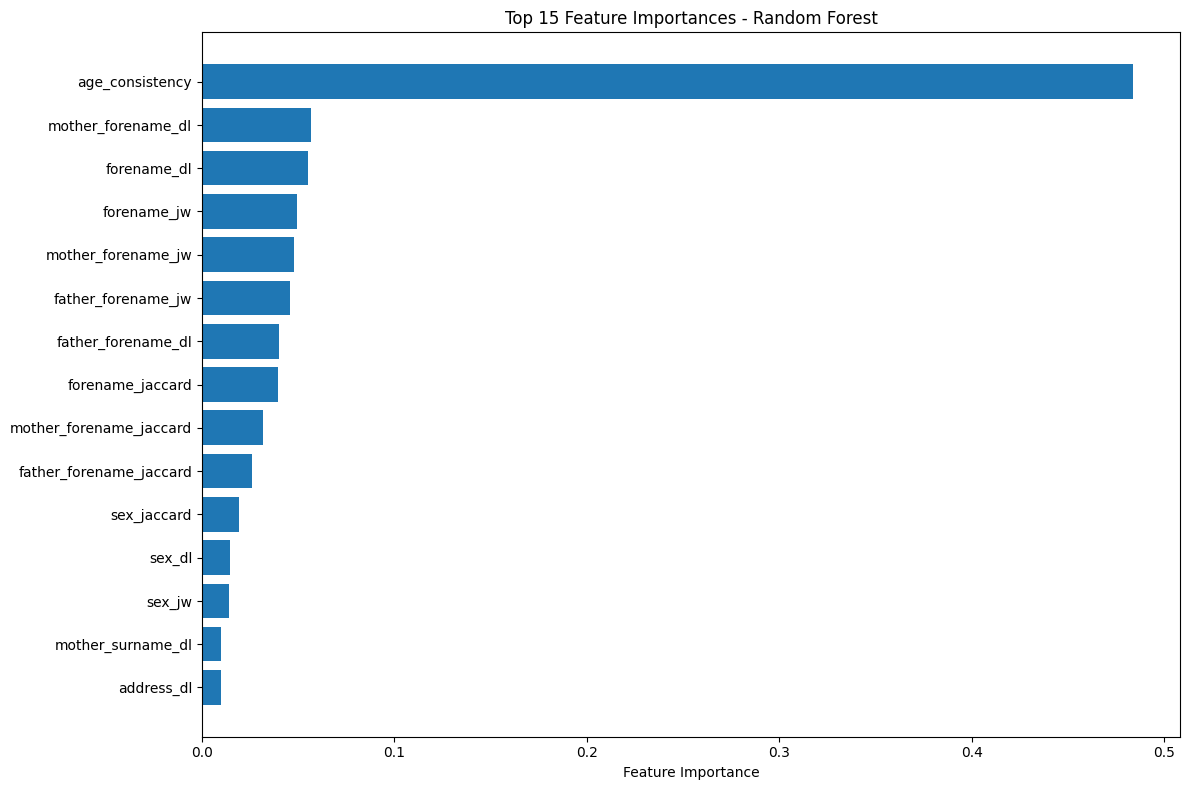

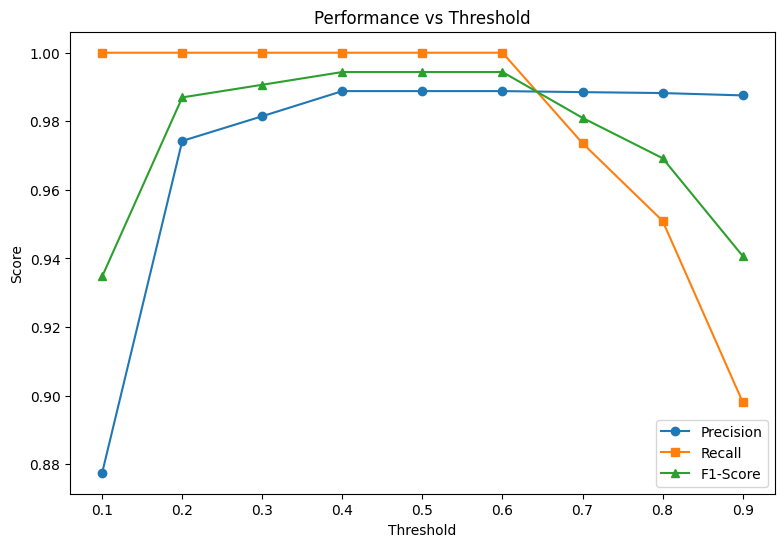


Cross-Validation Summary:
5-Fold Stratified Cross-Validation Results:
Precision: 0.9823 (+/- 0.0254)
Recall: 0.9854 (+/- 0.0239)
F1: 0.9838 (+/- 0.0198)

Final Model Performance on Test Set:
Total record pairs evaluated: 1312
Actual matches in test set: 265
Predicted matches in test set: 268
True positives: 265
False positives: 3
False negatives: 0
True negatives: 126

Test Set Performance:
Precision: 0.9888
Recall: 1.0000
F1-Score: 0.9944

Sample predictions:
   birth_id  death_id  actual_label  predicted_label  prediction_probability
0      4165      4165             0                0                0.001197
1      3555      3827             0                0                0.000493
2      3108      4190             1                1                0.919380
3      3619      3619             1                1                0.954575
4      5299      5299             1                1                0.910375
5      5331      5331             1                1                0.94

In [21]:

# %% [markdown]
# ## Step 5: Evaluation

# %%
# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Results:")
print("=" * 30)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# %%
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Match', 'Match'],
            yticklabels=['No Match', 'Match'])
plt.title('Confusion Matrix - Birth-Death Record Linkage')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# %%
# Feature importance analysis
feature_names = []
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'mother_forename', 'mother_surname', 'address']

for col in string_cols:
    feature_names.extend([f'{col}_jw', f'{col}_dl', f'{col}_jaccard'])
feature_names.append('age_consistency')

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# %%
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %%
# Analyze prediction probabilities
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No Match', color='red')
# plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Match', color='blue')
# plt.xlabel('Prediction Probability')
# plt.ylabel('Frequency')
# plt.title('Distribution of Prediction Probabilities')
# plt.legend()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int) 
    # the cutoff point of pred_proba to know what probabilities should we say "this is a match"
    if np.sum(y_pred_thresh) > 0:
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance vs Threshold')
plt.legend()
# plt.grid(True)

# plt.tight_layout()
plt.show()

# %%
# Summary statistics
print("\nCross-Validation Summary:")
print("=" * 50)
print("5-Fold Stratified Cross-Validation Results:")
for metric in metrics:
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")

print("\nFinal Model Performance on Test Set:")
print("=" * 50)
print(f"Total record pairs evaluated: {len(candidate_pairs)}")
print(f"Actual matches in test set: {np.sum(y_test)}")
print(f"Predicted matches in test set: {np.sum(y_pred)}")
print(f"True positives: {cm[1,1]}")
print(f"False positives: {cm[0,1]}")
print(f"False negatives: {cm[1,0]}")
print(f"True negatives: {cm[0,0]}")
print(f"\nTest Set Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%
# Save results (optional)
results_df = pd.DataFrame({
    'birth_id': [candidate_pairs[i][0] for i in range(len(X_test))],
    'death_id': [candidate_pairs[i][1] for i in range(len(X_test))],
    'actual_label': y_test,
    'predicted_label': y_pred,
    'prediction_probability': y_pred_proba
})

print(f"\nSample predictions:")
print(results_df.head(10))